# Predicting POS tags on Wikipedia

This report focuses on predicting POS tags on Wikipedia content using the node2vec method.

Node2Vec: https://snap.stanford.edu/node2vec/
Dataset used: http://www.mattmahoney.net/dc/textdata


In [2]:
from igraph import Graph
import igraph as ig
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
from scipy import sparse

## Data

The data used can be found at http://www.mattmahoney.net/dc/textdata

Data format is a sparse matrix and needs to be converted first.

- group:
    - size -> 4777x40
    - node labels as one-hot vectors representing the POS tags
- network: 4777x4777

### Importing the data

In [4]:
from report import DataImport

data = DataImport('./data/Homo_sapiens.mat')
data.group

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [78]:
# homo sapiens data seems to be unweighted
hs = loadmat('./data/Homo_sapiens.mat', matlab_compatible=True)
nw = np.array(sparse.csr_matrix(hs['network']).todense())
grp = np.array(sparse.csr_matrix(hs['group']).todense())
grp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [3]:
# g = Graph.Load('./data/POS.mat', format='matlab')
mat = loadmat('./data/POS.mat', matlab_compatible=True)
group = sparse.csr_matrix(mat['group']).todense()
network = sparse.csr_matrix(mat['network']).todense()

In [82]:
np.array(group)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [5]:
print(group)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


### Exploring the data

Create a graph object on iGraph:

In [80]:
g = Graph.Adjacency(network, mode="undirected")
g.summary()

'IGRAPH U--- 4777 141481 -- '

[]

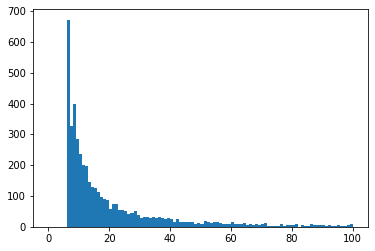

In [9]:
degree = g.degree()
plt.hist(degree, bins=100, range=(0,100))
plt.plot()

In [30]:
from stellargraph import StellarGraph

2022-05-10 09:01:12.955488: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
el = ig.Graph.get_edgelist(g)
el = np.array(el)
sources = el[:,0]
targets = el[:,1]

edges = pd.DataFrame(
    {"source": sources, "target": targets}
)
sg = StellarGraph(edges=edges)

In [36]:
print(sg.info())

StellarGraph: Undirected multigraph
 Nodes: 4777, Edges: 141481

 Node types:
  default: [4777]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [141481]
        Weights: all 1 (default)
        Features: none


## Node2Vec

See demo at: https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-weighted-node-classification.html

### Random Walks

First, we configure the random walker:

In [14]:

from lib.WalkerConfig import WalkerConfig

n = 10              # (int, optional): Total number of random walks per root node
length = 10        # (int, optional): Maximum length of each random walk
p = 10.0             # (float, optional): Defines probability, 1/p, of returning to source node
q = 1.0             # (float, optional): Defines probability, 1/q, for moving to a node away from the source node
weighted = False    # (bool, optional): Indicates whether the walk is unweighted or weighted

# initiliazes default walker config
config = WalkerConfig()

Then we generate the random walks:

In [189]:
from stellargraph.data.explorer import BiasedRandomWalk

w = BiasedRandomWalk(sg)
walks = w.run(
    nodes=sg.nodes(), n=n, length=length, p=p, q=q, weighted=weighted, seed=123
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 47770


### Representation learning

The Word2Vec model can now be applied to the random walks obtained before.

In [1]:
config = {
    'size' : 128,
    'window' : 5,
    'min_count' : 0,
    'sg' : 1,
    'workers' : 1,
    'epochs' : 10,
    # max size of vocab should probably be lower
    'max_vocab_size': 1000000
}

In [2]:
from gensim.models import Word2Vec

model = Word2Vec(
    walks, vector_size=config['size'], window=config['window'], min_count=config['min_count'], sg=config['sg'], workers=config['workers'], epochs=config['epochs'],
    max_vocab_size=config['max_vocab_size']
)

NameError: name 'walks' is not defined

In [15]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
labels = np.array(group)
node_targets = labels[[int(node_id) for node_id in node_ids]]
np.array(node_targets[:,0])

NameError: name 'model' is not defined

## Downstream task: predicting labels

Logistic regression prediction

Shorter version:

In [ ]:
from lib.WalkerConfig import WalkerConfig
from lib.Word2VecConfig import Word2VecConfig
from lib.ProjectGraph import ProjectGraph
from lib.DataSet import DataSet

# initialize the graph with data
ds = DataSet('./data/Homo_sapiens.mat')
project = ProjectGraph(ds)

# create configs
wc = WalkerConfig()
w2vc = Word2VecConfig()

# generate embeddings
embedding_model = project.create_embeddings(wc, w2vc)

### Splitting data

In [5]:
# X will hold the 128-dimensional input features
X = embedding_model.node_embeddings()
# y holds the corresponding target values
label = 0 # which class label to predict?
y = embedding_model.node_label_targets(label)

NameError: name 'embedding_model' is not defined

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

NameError: name 'X' is not defined

In [197]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (3821, 128)
 y_train = (3821,)
 X_test = (956, 128)
 y_test = (956,)


### Classifier training

In [198]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [199]:
y_pred = clf.predict(X_test)

We can concat the different class predictions to get 1 F1 and accuracy score for the entire dataset. Considering we have some very rare classes, we might want to compare performance only for the most prevalent classes. In a bigger dataset, we would be able to solve this challenge as well.

In [202]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_score(y_test, y_pred)

0.5826359832635983

In [203]:
f1_score(y_test, y_pred)

0.44813278008298757

In [187]:
np.sum(node_targets, axis=0)

array([2.246e+03, 3.600e+02, 7.600e+01, 2.100e+01, 2.890e+02, 4.110e+02,
       1.690e+02, 7.770e+02, 9.390e+02, 1.000e+01, 1.000e+00, 3.000e+00,
       1.880e+02, 1.000e+00, 4.220e+02, 4.000e+00, 1.000e+00, 1.700e+01,
       1.300e+01, 2.990e+02, 1.200e+01, 1.000e+00, 3.000e+00, 1.100e+01,
       2.000e+00, 6.000e+00, 7.000e+00, 1.000e+00, 4.010e+02, 3.000e+00,
       5.000e+00, 2.000e+00, 7.000e+00, 2.200e+01, 1.700e+01, 1.000e+00,
       1.800e+01, 1.000e+00, 2.000e+00, 1.000e+00])

In [167]:
node_targets

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Varying parameters

Which parameters to investigate?

#### Random Walk

- p
- q
- length of walk
- nr of walks

#### Word2Vec

- size (dimension of feature vector)
- window (length of word context)
- epochs

#### Classifier

